### Modeling COCO - QA
* [Review](https://arxiv.org/abs/1610.01465)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_cpu_metrics import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings_vlm/coco-qa/'
FILE = 'embeddings_blip2.csv'

FILE_PATH = os.path.join(PATH, FILE)

## Get data

In [3]:
df = pd.read_csv(FILE_PATH)
df.drop(columns=['image_id'], inplace=True)
df.head()

,questions,answers,types,split,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,what is using umbrellas as a central theme,sculpture,0,train,0.910112,0.047912,0.599758,0.811695,0.795265,0.960603,...,-0.049749,-0.334483,0.783461,-0.115713,0.502651,-0.638148,-0.121507,-1.375205,-0.071451,-0.133267
1,what walks toward the rope perimeter fence,elephant,0,train,0.467127,0.134101,0.469607,0.704712,0.764678,0.807092,...,0.029792,-0.316745,0.616901,-0.033126,0.329823,-0.644164,-0.119549,-1.200152,0.049828,0.050474
2,what is the color of the horses,brown,2,train,0.826972,0.030232,0.593160,0.785447,0.761188,0.959835,...,0.078826,-0.361225,0.694186,0.015087,0.556272,-0.514775,-0.147644,-1.454061,-0.107706,-0.064445
3,where is the black cat laying down,sink,3,train,0.504895,0.081780,0.528665,0.810781,0.666322,0.840913,...,0.069596,-0.338071,0.681182,0.113006,0.357360,-0.598674,-0.143003,-1.420788,0.066972,0.141735
4,what is the color of the character,purple,2,train,0.431480,0.135572,0.520458,1.011481,0.878144,0.702918,...,0.047705,-0.561572,0.623299,0.090776,0.123035,-0.526186,-0.005628,-1.467347,-0.039561,-0.134407


## Data Perparation

In [4]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors. 
# In this case, since we just have multimodal embeddings instead of unimodal embeddings,
# We'll split the column into half and half so we can use the same code.
# Identify columns with "embedding_" in their names
embedding_columns = [column for column in df.columns if 'embedding_' in column]

# Split the embedding columns evenly between text and image columns
num_embeddings = len(embedding_columns)
half_num_embeddings = num_embeddings // 2

text_columns = embedding_columns[:half_num_embeddings]
image_columns = embedding_columns[half_num_embeddings:]

label_columns = 'answers'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (77867, 772)
Test Shape: (38525, 772)


### Models

In [5]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = len(mlb.classes_)
multilabel = False

Training Early Fusion Model:
Model Memory Usage: 0.59 MB
The number of parameters of the model are: 154158


STAGE:2024-02-07 19:09:49 10811:10811 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Epoch 1/10 - Test Accuracy: 0.0162
Epoch 1/10 - Training Time: 5.73 seconds | Inference Time: 2.77 seconds
Epoch 2/10 - Test Accuracy: 0.0121
Epoch 2/10 - Training Time: 6.12 seconds | Inference Time: 2.82 seconds
Epoch 3/10 - Test Accuracy: 0.0109
Epoch 3/10 - Training Time: 5.86 seconds | Inference Time: 2.89 seconds
Epoch 4/10 - Test Accuracy: 0.0061
Epoch 4/10 - Training Time: 6.58 seconds | Inference Time: 3.05 seconds
Epoch 5/10 - Test Accuracy: 0.0009
Epoch 5/10 - Training Time: 5.86 seconds | Inference Time: 3.18 seconds
Epoch 6/10 - Test Accuracy: 0.0096
Epoch 6/10 - Training Time: 6.20 seconds | Inference Time: 3.21 seconds
Epoch 7/10 - Test Accuracy: 0.0005
Epoch 7/10 - Training Time: 6.13 seconds | Inference Time: 3.24 seconds
Epoch 8/10 - Test Accuracy: 0.0016
Epoch 8/10 - Training Time: 7.02 seconds | Inference Time: 3.23 seconds
Epoch 9/10 - Test Accuracy: 0.0005
Epoch 9/10 - Training Time: 6.65 seconds | Inference Time: 3.32 seconds
Epoch 10/10 - Test Accuracy: 0.0015
E

STAGE:2024-02-07 19:11:35 10811:10811 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-07 19:11:36 10811:10811 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         training_batch         8.78%        7.013s        55.43%       44.277s       3.638ms      -3.47 Gb      -4.92 Gb         12170  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        35.96%       28.728s        36.59%       29.229s       1.605ms       5.19 Gb       5.18 Gb         18210  
                              Optimizer.step#AdamW.step         5.86%        4.679s        18.26%       14.588s       1.199ms       1.18 Mb     -13.83

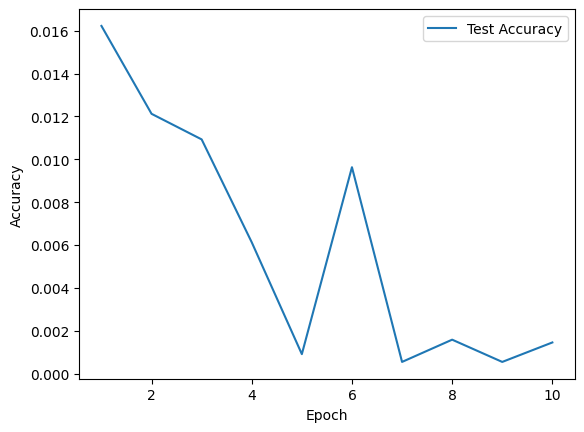

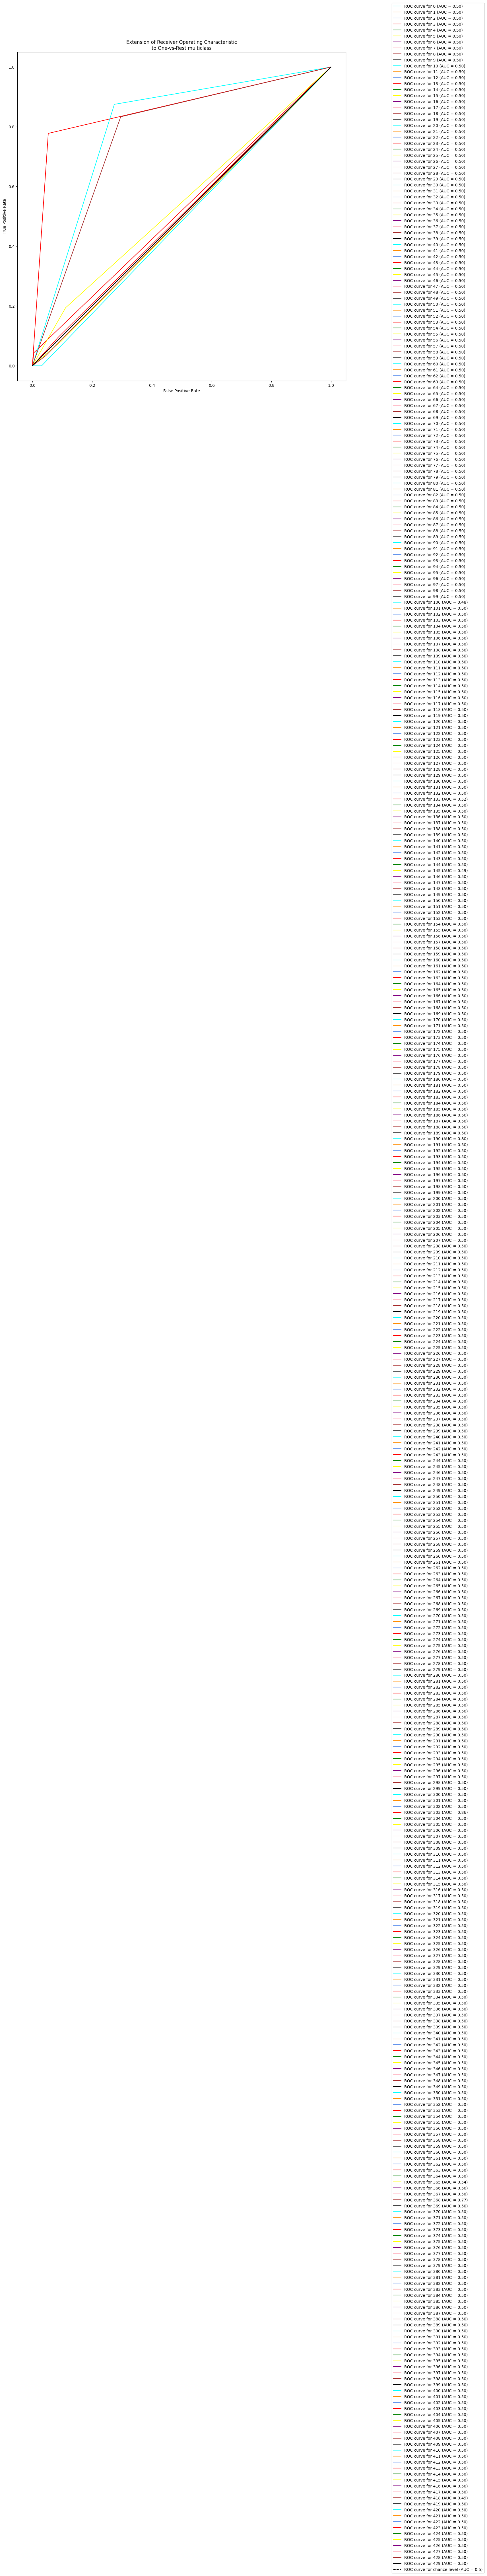

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00       439
           2       0.00      0.00      0.00       163
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        21
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        52
          12       0.00      0.00      0.00        29
          13       0.00      0.00      0.00       309
          14       0.00      0.00      0.00       115
          15       0.00      0.00      0.00        97
          16       0.00      0.00      0.00         7
          17       0.00    

In [6]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=10, multilabel=multilabel, report=True, p=0.2)